## Procedural memory

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [1]:
# %%capture cap --no-stderr
# %pip install -U langmem langgraph

In [1]:
from langgraph.store.memory import InMemoryStore

store = InMemoryStore()
store.put(("instructions",), key="agent_instructions", value={"prompt": "Write good emails."})

In [4]:
from langgraph.prebuilt import create_react_agent
from langgraph.config import get_store

def draft_email(to: str, subject: str, body: str):
    """Submit an email draft."""
    return "Draft saved successfully."

def prompt(state):
    item = store.get(("instructions",), key="agent_instructions")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

agent = create_react_agent("openai:gpt-4o", prompt=prompt, tools=[draft_email], store=store)

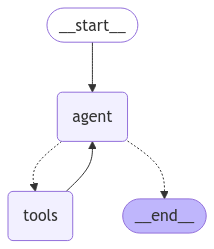

In [6]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [5]:
result = agent.invoke(
    {"messages": [
        {"role": "user", "content" :"Draft an email to joe@langchain.dev saying that we want to schedule a followup meeting for thursday at noon."}]}
)
result['messages'][1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  draft_email (call_nsHUdragensMGzlVuU99ulaa)
 Call ID: call_nsHUdragensMGzlVuU99ulaa
  Args:
    to: joe@langchain.dev
    subject: Schedule Follow-up Meeting
    body: Hi Joe,

I hope this message finds you well. I’m writing to propose scheduling our follow-up meeting for this Thursday at noon. Please let me know if this time works for you, or if there are any other times that would be better.

Looking forward to our discussion.

Best regards,

[Your Name]
[Your Position]
[Your Company]
[Your Contact Information]


# Update the prompt

In [8]:
from langmem import create_prompt_optimizer

optimizer = create_prompt_optimizer("openai:gpt-4o")

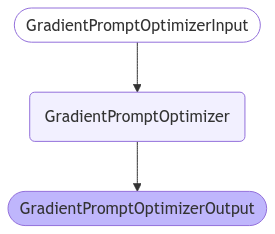

In [11]:
display(Image(optimizer.get_graph().draw_mermaid_png()))

In [9]:
current_prompt = store.get(("instructions",), key="agent_instructions").value["prompt"]
feedback = {"request": "Always sign off from 'William'; for meeting requests, offer to schedule on Zoom or Google Meet"}

optimizer_result = optimizer.invoke({"prompt": current_prompt, "trajectories": [(result["messages"], feedback)]})

In [10]:
print(optimizer_result)

Write good emails that address the recipient personally and include your signature as 'William'. When drafting emails about meetings, suggest scheduling options via Zoom or Google Meet to better align with user preferences for digital meetings.


In [12]:
store.put(("instructions",), key="agent_instructions", value={"prompt": optimizer_result})

In [13]:
result = agent.invoke(
    {"messages": [
        {"role": "user", "content" :"Draft an email to joe@langchain.dev saying that we want to schedule a followup meeting for thursday at noon."}]}
)
result['messages'][1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  draft_email (call_rl3qPzFpiQeHVog7rir4zZtz)
 Call ID: call_rl3qPzFpiQeHVog7rir4zZtz
  Args:
    to: joe@langchain.dev
    subject: Follow-up Meeting Schedule
    body: Hi Joe,

I hope this message finds you well. I wanted to propose scheduling our follow-up meeting for this Thursday at noon. Please let me know if this time works for you or if there are alternative times that you prefer. We can set up the meeting via Zoom or Google Meet, depending on your preference.

Looking forward to our discussion.

Best regards,

William


In [14]:
result = agent.invoke(
    {"messages": [
        {"role": "user", "content" : "Let roger@langchain.dev know that the release should be later by 4:00 PM."}]}
)
result['messages'][1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  draft_email (call_OjZA9KFlEU4Uav2h8mQRFXIn)
 Call ID: call_OjZA9KFlEU4Uav2h8mQRFXIn
  Args:
    to: roger@langchain.dev
    subject: Update on Release Timing
    body: Hi Roger,

I hope this message finds you well. I wanted to let you know that the scheduled release should be pushed later to 4:00 PM.

If you have any questions or need further adjustments, please feel free to reach out.

Best regards,

William


## Multi-agent

In [15]:
# %%capture cap --no-stderr
# %pip install -U langgraph-supervisor

In [16]:
from langgraph.store.memory import InMemoryStore
from langgraph.prebuilt import create_react_agent
from langgraph.config import get_store

store = InMemoryStore()

store.put(("instructions",), key="email_agent", value={"prompt": "Write good emails. Repeat your draft content to the user after submitting."})
store.put(("instructions",), key="twitter_agent", value={"prompt": "Write fire tweets. Repeat the tweet content to the user upon submission."})

## Email agent
def draft_email(to: str, subject: str, body: str):
    """Submit an email draft."""
    return "Draft saved succesfully."

def prompt_email(state):
    item = store.get(("instructions",), key="email_agent")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

email_agent = create_react_agent(
    "openai:gpt-4o",
    prompt=prompt_email, 
    tools=[draft_email], 
    store=store,
    name="email_assistant",
)

## Tweet

def tweet(to: str, subject: str, body: str):
    """Poast a tweet."""
    return "Legendary."

def prompt_social_media(state):
    item = store.get(("instructions",), key="twitter_agent")
    instructions = item.value["prompt"]
    sys_prompt = {"role": "system", "content": f"## Instructions\n\n{instructions}"}
    return [sys_prompt] + state['messages']

social_media_agent = create_react_agent(
    "openai:gpt-4o",
    prompt=prompt_social_media, 
    tools=[tweet], 
    store=store,
    name="social_media_agent",
)

In [17]:
from langgraph_supervisor import create_supervisor

# Create supervisor workflow
workflow = create_supervisor(
    [email_agent, social_media_agent],
    model="openai:gpt-4o",
    prompt=(
        "You are a team supervisor managing email and tweet assistants to help with correspondence."
    )
)

# Compile and run
app = workflow.compile(store=store)

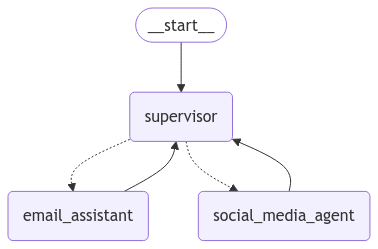

In [18]:
display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
result = app.invoke(
    {"messages": [
        {"role": "user", "content" :"Draft an email to joe@langchain.dev saying that we want to schedule a followup meeting for thursday at noon."}]},
)

In [20]:
result["messages"][3].pretty_print()

================================== Ai Message ==================================
Name: email_assistant

The email draft to Joe has been successfully created. Here's what it says:

Subject: Schedule a Follow-up Meeting

Body:
Hi Joe,

I hope this message finds you well. I am writing to propose scheduling a follow-up meeting for this Thursday at noon. Please let me know if this time works for you or if there is another time that you would prefer.

Looking forward to our discussion.

Best regards,

[Your Name]


In [21]:
from langmem import create_multi_prompt_optimizer

feedback = {"request": "Always sign off emails from 'William'; for meeting requests, offer to schedule on Zoom or Google Meet"}

optimizer = create_multi_prompt_optimizer("openai:gpt-4o")

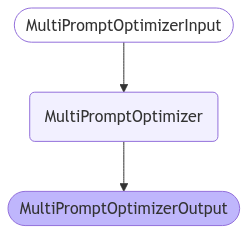

In [22]:
display(Image(optimizer.get_graph().draw_mermaid_png()))

In [23]:
from langmem import Prompt
?Prompt

In [24]:
email_prompt = store.get(("instructions",), key="email_agent").value['prompt']
tweet_prompt = store.get(("instructions",), key="twitter_agent").value['prompt']

email_prompt = {
    "name": "email_prompt",
    "prompt": email_prompt,
    "when_to_update": "Only if feedback is provided indicating email writing performance needs improved."
}
tweet_prompt = {
    "name": "tweet_prompt",
    "prompt": tweet_prompt,
    "when_to_update": "Only if tweet writing generation needs improvement."
}


optimizer_result = optimizer.invoke({"prompts": [tweet_prompt, email_prompt], "trajectories": [(result["messages"], feedback)]})

In [25]:
optimizer_result

[{'name': 'tweet_prompt',
  'prompt': 'Write fire tweets. Repeat the tweet content to the user upon submission.',
  'when_to_update': 'Only if tweet writing generation needs improvement.'},
 {'name': 'email_prompt',
  'prompt': "Write good emails that align with user preferences. Incorporate the user's specified sign-off (e.g., 'William') and suggest meeting times using preferred platforms (like Zoom or Google Meet). Repeat the draft content to the user after submitting.",
  'when_to_update': 'Only if feedback is provided indicating email writing performance needs improved.'}]

In [26]:
store.put(("instructions",), key="email_agent", value={"prompt": optimizer_result[1]['prompt']})

In [27]:
result = app.invoke(
    {"messages": [
        {"role": "user", "content" :"Draft an email to joe@langchain.dev saying that we want to schedule a followup meeting for thursday at noon."}]},
)

In [28]:
result["messages"][3].pretty_print()

================================== Ai Message ==================================
Name: email_assistant

I've drafted the following email for you:

Subject: Follow-up Meeting Schedule

Hi Joe,

I hope this message finds you well. I wanted to propose scheduling a follow-up meeting for this Thursday at noon. We can use your preferred platform, whether it's Zoom or Google Meet. Please let me know if this time works for you or if there's another that you prefer.

Looking forward to our conversation.

Best,
William


In [33]:
result = app.invoke(
    {"messages": [
        {"role": "user", "content" :"Write a tweet about the beautiful of the world."}]},
)

In [34]:
result["messages"][3].pretty_print()

================================== Ai Message ==================================
Name: social_media_agent

Here's your tweet about the beauty of the world:

"The world is a stunning masterpiece painted with sunsets, starlit skies, and oceans vast. Its beauty lies in the melody of the chirping birds and in the serene silence of the mountains. Let's cherish and protect this breathtaking planet we call home! 🌍✨"


In [45]:
result = app.invoke(
    {"messages": result["messages"] + [
        {"role": "user", "content" :"Write a tweet about the bad of the war."}]},
)

In [46]:
result["messages"][-1].pretty_print()

================================== Ai Message ==================================
Name: supervisor

The social media assistant crafted this insightful tweet for you:

"War leaves behind scars deeper than any weapon can carve. It steals futures, shatters families, and paints lands with sorrow and loss. The human spirit bears unimaginable burdens under its weight. It's a stark reminder of the urgent need for peace. #NoToWar #Peace"
